# Supervised Capstone: Predicting Zillow Zestimate residual error (logerror). 

By Karen McGee

My supervised Capstone project is seeking to determine the best model to use for predicting the Zillow Zestimate residual error (i.e. logerror).

In [1]:
# GOAL of the Capstone Project: Build a model to improve the zillow Zestimate residual error (also know as the log-error)
#(i.e “Zestimates” are estimated home values based).

#Source: The dataset was acquired from Kaggle. Two files were provided, one is related to the property
#features and the other file (i.e training file) contains the log-error, which is the output variable. 

#Description: In this competition, Zillow is asking you to build a model that will predict the 
#zillow Zestimate residual error (aka as log-error) given all the property features of a home.
#The log error is defined as logerror=log(Zestimate)−log(SalePrice)and it is recorded in the 
#transactions file train.csv.

#Approach: 1. Load the data
#           2. clean and explore data (i.e correlations or histograms)
#           3. split data into training and testing set
#           4. run the data againts 4 models to determine the 
#               algorithm that will produce the best log error.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots
import warnings # us to hide warning related to parameter defaults and data type conversions
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline


# Why predict the Zillow Zestimate residual error (logerror)?

Zillow has been providing zestimate scores for several years. As a real estate landlord, I have always been curious as to how the Zestimate scores are created, and how they are able to improve the score.

# What is the Zillow Zestimate residual error (i.e. logerror)?

The log error is defined as log(Zestimate)−log(SalePrice).


# Research Questions:

Is there a strong correlations between the property features and the logerror?
What is the best model to use for predicting the logerror?
What are the most important features used by the strongest performing model?

# Gathering Data:

Today I will be presenting my analaysis and models based on 2017 property dataset, which contains features that can be used to determine the value of a house. Understanding the features and it's relationship to the logerror, can be used to to help a model increase the accuracy of the logerror prediction. The following links below are sites I used to gather more information about the dataset. 

https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65 
https://becominghuman.ai/a-sub-optimal-approach-for-predicting-real-estate-prices-by-zillow-ad1bcd8197cd
https://kennylouie.gitlab.io/2018/07/24/Part-1-Zestimate-Kaggle-Competition/
https://www.kaggle.io/svf/1594540/66393d2205687a043743bf8cb965e4be/__results__.html
https://github.com/SheldonGeek/Machine-Learning-CapStone-Project/blob/master/capstone.ipynb
https://www.kaggle.com/c/zillow-prize-1/discussion/33899

In [3]:
#The Zillow file is a big file and creates slow performance on my machine 
#therefore, I need to a function that will reduce the size of the file by addressing the NaN
#values and converting columns to integers or converting the size of the integer datatype
#to a smaller datatype. 

# Clean the properties dataset for missing and NaN values on interger columns

In [4]:
#define a procedure to reduce the file size by identifying and changing the data types of 
#each of the fields to intergers. The function will also identify the columns with missing values
#and populate values for them.

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.int8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.int16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.int32)
                    else:
                        props[col] = props[col].astype(np.int64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [5]:
#Load the properties files that contain our features and the training file
#that contain our outcome variable logerror
df_zhs = pd.read_csv('properties_2017.csv')
train = pd.read_csv('train_2017.csv')

/Users/karenmcgee/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#call the function to reduce the file size, print the before and after data types of 
#each integer field that we change. Also print the columns that were identified as having 
#missing values and populate the values.

df_zhs, NAlist = reduce_mem_usage(df_zhs)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1320.9731750488281  MB
******************************
Column:  parcelid
dtype before:  int64
dtype after:  int32
******************************
******************************
Column:  airconditioningtypeid
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  architecturalstyletypeid
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  basementsqft
dtype before:  float64
dtype after:  int16
******************************
******************************
Column:  bathroomcnt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  bedroomcnt
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  buildingclasstypeid
dtype before:  float64
dtype after:  int8
******************************
*****************************

In [7]:
#view the dataframe to see the columns and values for the first 5 rows
df_zhs.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,0,1,19,0.0,0,0,0,0.0,65,...,0,NaN,0,9,2016,9,-0.760000,NaN,-1,-2
1,10759547,0,1,19,0.0,0,0,0,0.0,65,...,0,NaN,0,27516,2015,27516,-0.760000,NaN,-1,-2
2,10843547,0,1,19,0.0,0,5,0,0.0,65,...,1,NaN,660680,1434941,2016,774261,20800.369141,NaN,-1,-2
3,10859147,0,1,19,0.0,0,3,6,0.0,65,...,1,NaN,580059,1174475,2016,594416,14557.570312,NaN,-1,-2
4,10879947,0,1,19,0.0,0,4,0,0.0,65,...,1,NaN,196751,440101,2016,243350,5725.169922,NaN,-1,-2


In [8]:
#view the dataframe to see the columns and values for the first 5 rows
train.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


In [9]:
#view the number of rows and columns of the dataframe
print('Shape of the properties_2017 dataset:', df_zhs.shape)
print('Shape of the train_2017 dataset:', train.shape)

Shape of the properties_2017 dataset: (2985217, 58)
Shape of the train_2017 dataset: (77613, 3)


# Clean non numerical data

In [10]:
#shows the remaining colums with missing values only
missing_val_count_by_column = (df_zhs.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

hashottuborspa               2935155
propertycountylandusecode       2999
propertyzoningdesc           1002746
fireplaceflag                2980054
taxdelinquencyflag           2928702
dtype: int64


In [11]:
#verify the remaining null columns are of type object
# generic syntax to grab all columns not equal to type object
X_data=df_zhs.dtypes[df_zhs.dtypes=='object'].index
X_data

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag'],
      dtype='object')

In [12]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['hashottuborspa'].value_counts(dropna=False)

NaN     2935155
True      50062
Name: hashottuborspa, dtype: int64

In [13]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['fireplaceflag'].value_counts(dropna=False)

NaN     2980054
True       5163
Name: fireplaceflag, dtype: int64

In [14]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['taxdelinquencyflag'].value_counts(dropna=False)

NaN    2928702
Y        56515
Name: taxdelinquencyflag, dtype: int64

In [15]:
#based on the above I would convert the column to a int by converting the true 
#values into 1 and NaN's into 0 and then performing a dtype conversion on the column.

#use get_dummies to turn the categorical values into integers
df_zhs['hashottuborspaflag'] = pd.get_dummies(df_zhs['hashottuborspa'],dtype=int)
df_zhs['fireplaceflagNF'] = pd.get_dummies(df_zhs['fireplaceflag'],dtype=int)
df_zhs['taxdelinquencyflagNF'] = pd.get_dummies(df_zhs['taxdelinquencyflag'],dtype=int)

In [16]:
#verify the new field has been converted to a numerical column
df_zhs['hashottuborspaflag'].value_counts(dropna=False)

0    2935155
1      50062
Name: hashottuborspaflag, dtype: int64

In [17]:
#verify the new field has been converted to a numerical column
df_zhs['fireplaceflagNF'].value_counts(dropna=False)

0    2980054
1       5163
Name: fireplaceflagNF, dtype: int64

In [18]:
#verify the new field has been converted to a numerical column
df_zhs['taxdelinquencyflagNF'].value_counts(dropna=False)

0    2928702
1      56515
Name: taxdelinquencyflagNF, dtype: int64

In [19]:
#verify the new fields have been added to the data frame
df_zhs.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,hashottuborspaflag,fireplaceflagNF,taxdelinquencyflagNF
0,10754147,0,1,19,0.0,0,0,0,0.0,65,...,9,2016,9,-0.760000,NaN,-1,-2,0,0,0
1,10759547,0,1,19,0.0,0,0,0,0.0,65,...,27516,2015,27516,-0.760000,NaN,-1,-2,0,0,0
2,10843547,0,1,19,0.0,0,5,0,0.0,65,...,1434941,2016,774261,20800.369141,NaN,-1,-2,0,0,0
3,10859147,0,1,19,0.0,0,3,6,0.0,65,...,1174475,2016,594416,14557.570312,NaN,-1,-2,0,0,0
4,10879947,0,1,19,0.0,0,4,0,0.0,65,...,440101,2016,243350,5725.169922,NaN,-1,-2,0,0,0


In [20]:
#merge the training and properties file by parcelid to ensure the model is calculating values found in each file
df_train = df_zhs.merge(train, how='inner', on='parcelid')

In [21]:
#let's see how many rows and columns we have after the merger. Before we had (2985217, 58)
print('Show the shape of the df_train dataset:', df_train.shape)

Show the shape of the df_train dataset: (77613, 63)


In [22]:
#Check again to see if there are any missing values
missing_val_count_by_column = (df_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

hashottuborspa               76074
propertycountylandusecode       34
propertyzoningdesc           27137
fireplaceflag                77441
taxdelinquencyflag           74713
dtype: int64


In [23]:
#view the new data frame and validate the newly merge columns are in the dataframe
df_train.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,hashottuborspaflag,fireplaceflagNF,taxdelinquencyflagNF,logerror,transactiondate
0,17054981,0,1,19,5.0,4,0,0,5.0,65,...,370922,9673.459961,NaN,-1,61110009011034,0,0,0,-0.013099,2017-06-15
1,17055743,0,1,19,2.0,3,0,0,2.0,66,...,305312,5538.799805,NaN,-1,61110009034011,0,0,0,0.073985,2017-07-26
2,17068109,0,1,19,1.5,3,0,0,1.5,66,...,93193,2987.360107,NaN,-1,61110012061086,0,0,0,0.071886,2017-07-28
3,17073952,0,1,19,2.0,2,0,0,2.0,65,...,168531,2706.239990,NaN,-1,61110022003001,0,0,0,0.305680,2017-06-02
4,17078502,0,1,19,1.0,2,0,0,1.0,65,...,444178,6220.700195,NaN,-1,61110019002015,0,0,0,-0.073787,2017-07-07


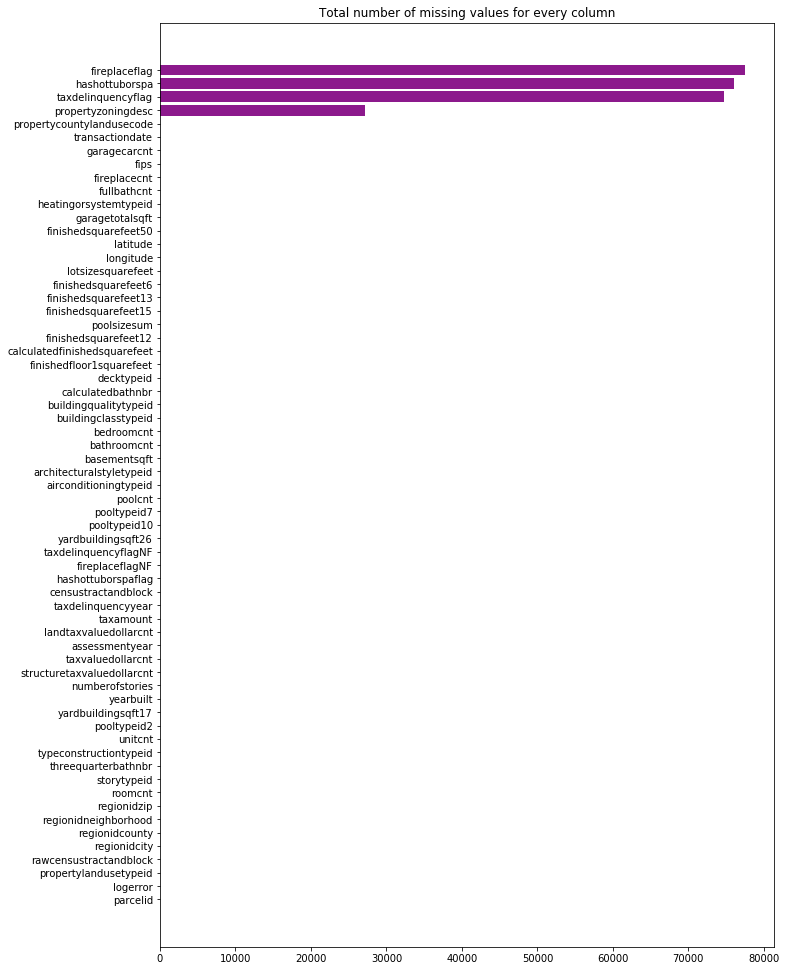

In [24]:
#create a plot to show the missing columns

missing_val_count_by_column = df_train.isnull().sum(axis=0).reset_index()
missing_val_count_by_column.columns = ['names', 'counts']
missing_val_count_by_column = missing_val_count_by_column.sort_values(by='counts')

fig, axes = plt.subplots(figsize=(11,17))
axes.barh(np.arange(missing_val_count_by_column.shape[0]), missing_val_count_by_column.counts.values, alpha=0.9,color='purple')
axes.set_title("Total number of missing values for every column")
axes.set_yticks(np.arange(missing_val_count_by_column.shape[0]))
axes.set_yticklabels(missing_val_count_by_column.names.values, rotation='horizontal')
plt.show()


# Explore data of our features and predictor variables

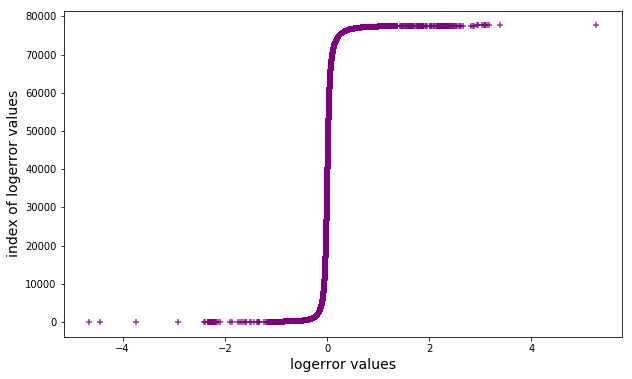

In [25]:
#let's take a look at the data specifically the logerror and determine
# if we have outliers.

plt.figure(figsize=(10,6))
x, y = pd.Series(np.sort(df_train.logerror.values), name="logerror values"), pd.Series(range(df_train.shape[0]), name="index of logerror values")
sns.regplot(x=x, y=y, marker="+",fit_reg=False,color='purple')
plt.xlabel('logerror values', fontsize=14)
plt.ylabel('index of logerror values', fontsize=14)
plt.show()


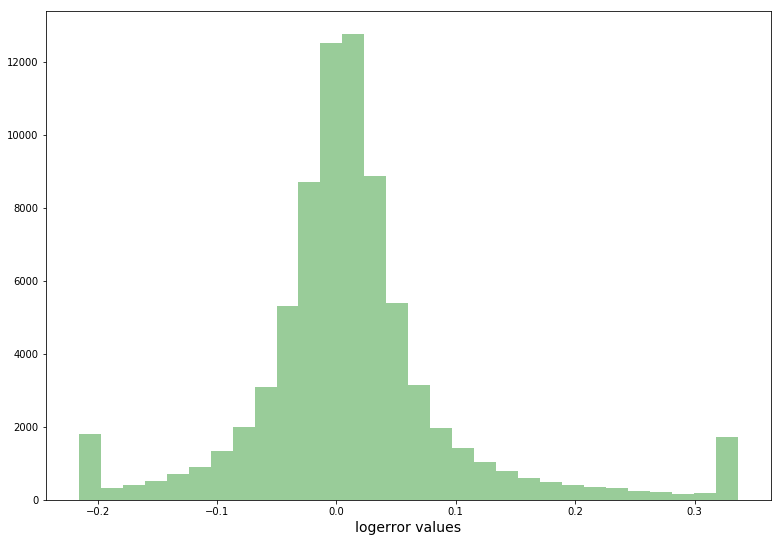

In [27]:
#Show the distributions of the output variable 
warnings.filterwarnings('ignore')
df_train['logerror'].loc[df_train['logerror']>np.percentile(df_train.logerror.values, 98)] = np.percentile(df_train.logerror.values, 98)
df_train['logerror'].loc[df_train['logerror']<np.percentile(df_train.logerror.values, 2)] = np.percentile(df_train.logerror.values, 2)

plt.figure(figsize=(13,9))
sns.distplot(df_train.logerror.values,kde=False,color='green', bins=30)
plt.xlabel('logerror values', fontsize=14)
plt.show()

In [28]:
#We can see from graph above, it has a good normal distribution. 
#Since logerror = log(Zestimate) - log(actual price), negative logerror value means the Zestimate is underestimated, 
#positive value means the Zestimate is overestimated. We can see from this normal distribution, 
#it estimates pretty accurate most of the time. We need to find out when Zesimate does well and when it doesn't. 
#We need to find out correlations between different features and logerror.

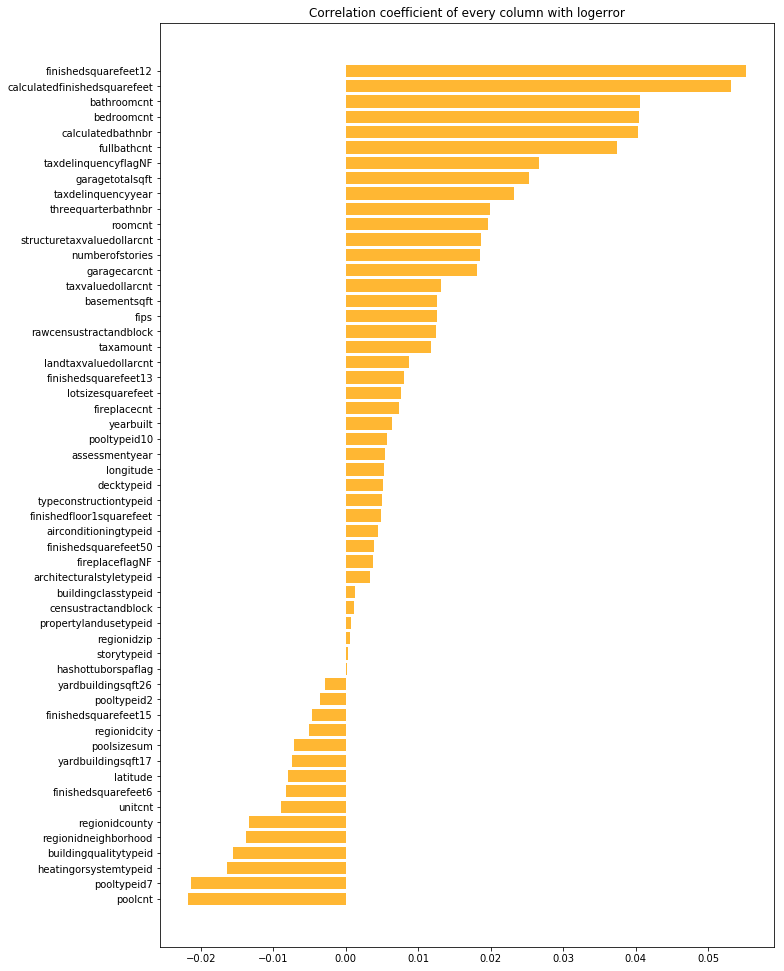

In [29]:
#merged_train_data_new = train_data_new
train_data_new = df_train.drop(["parcelid", "transactiondate"], axis=1)
columns = [col for col in train_data_new.columns 
           if train_data_new[col].dtype!='object' 
           if len(train_data_new[col].unique())!=1 
           if col not in ['logerror'] ]
lbls = [] 
vals = []
for column in columns:
    lbls.append(column)
    vals.append(np.corrcoef(train_data_new[column].values, train_data_new.logerror.values)[0,1])

correlation_data = pd.DataFrame({'lbls':lbls, 'vals':vals})
correlation_data = correlation_data.sort_values(by='vals')
fig, axes = plt.subplots(figsize=(11,17))
axes.barh(np.arange(correlation_data.shape[0]), correlation_data.vals.values, alpha=0.8,color='orange')
axes.set_title("Correlation coefficient of every column with logerror")
axes.set_yticks(np.arange(correlation_data.shape[0]))
axes.set_yticklabels(correlation_data.lbls.values, rotation='horizontal')
plt.show()

In [30]:
#Now let's remove from our x_train predictor variable the columns with data types equal to objects
X = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode','hashottuborspa','fireplaceflag','taxdelinquencyflag',
                  'storytypeid','regionidzip'], axis=1)
#x_train = np.asarray(x_train)
#create our y_train outcome variable 
#y = df_train[['logerror']]
y = df_train['logerror'] #shape will be(row total,)

print('The shape of X and y is: ', X.shape, y.shape)

#print(X.shape, y.shape)
#train_columns = x_train.columns

The shape of X and y is:  (77613, 53) (77613,)


In [31]:
#let's take a look at a few of the columns that have a high and low correlation. This will help us determine
#if the data is normalized based on it's distribution and if it isn't we should perform some kind of normaliation step before running the
#model.

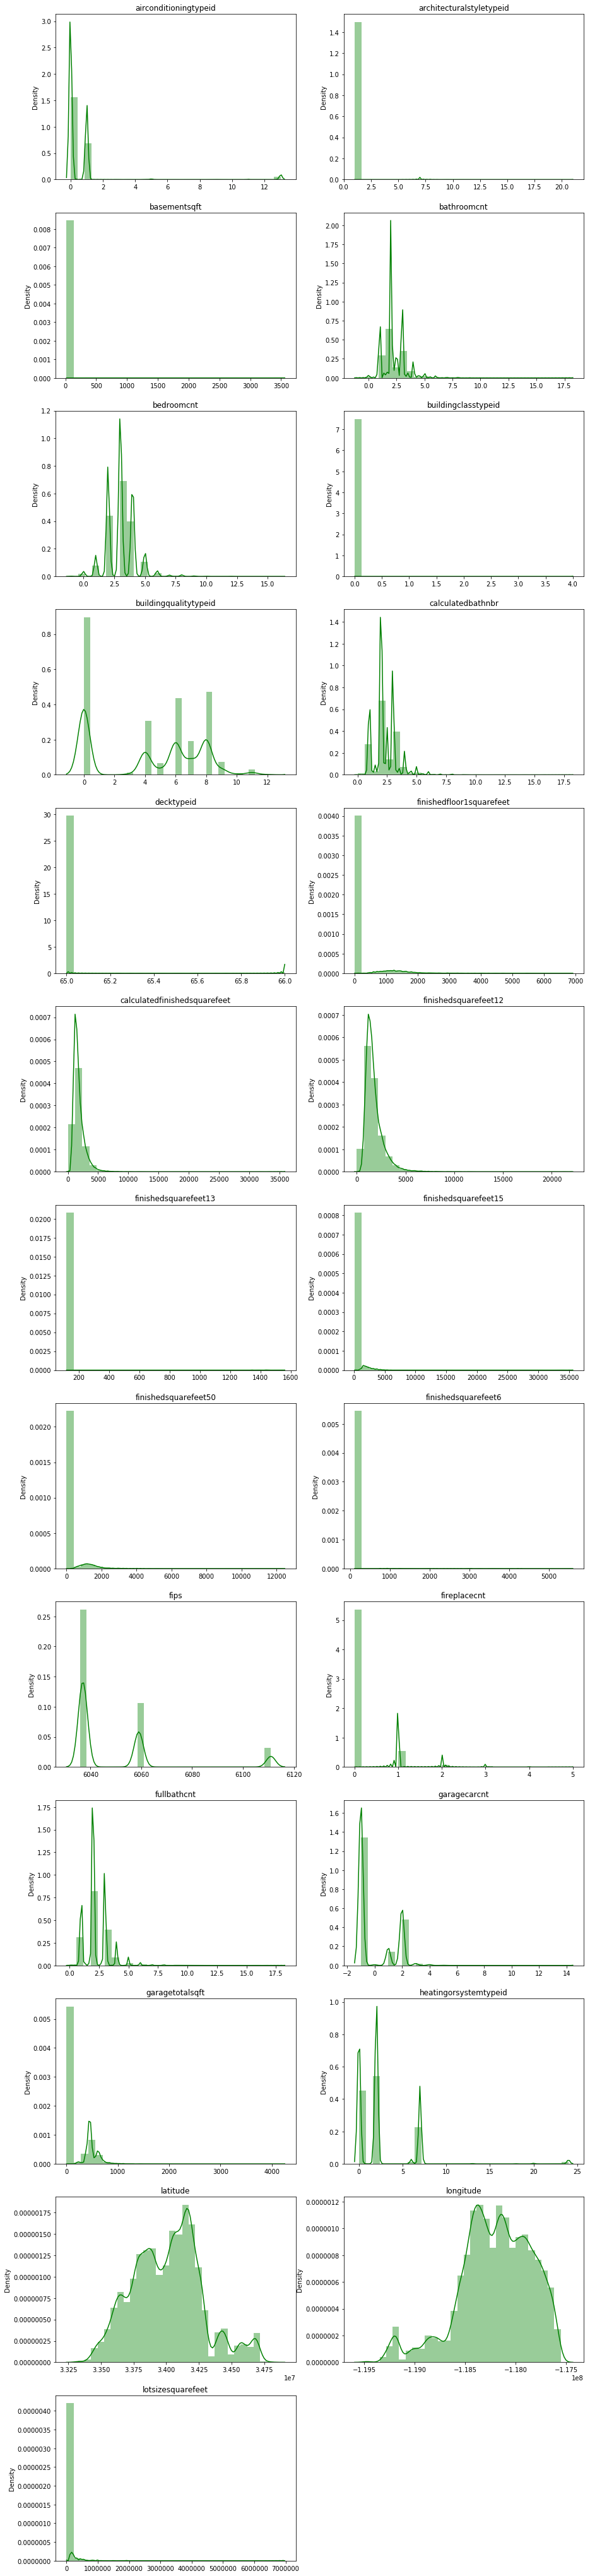

In [32]:
#hide the following warining by ignoring the warning
#Warning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
#warnings.warn("The 'normed' kwarg is deprecated, and has been "
import warnings
warnings.filterwarnings("ignore")


#Lets look at the distributions of the fisrst 25 columns of the table to get an idea of
#how the data is spread out.

columns = X.iloc[:,0:25].columns

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(X[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(X[col], bins = 30, color='g')
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

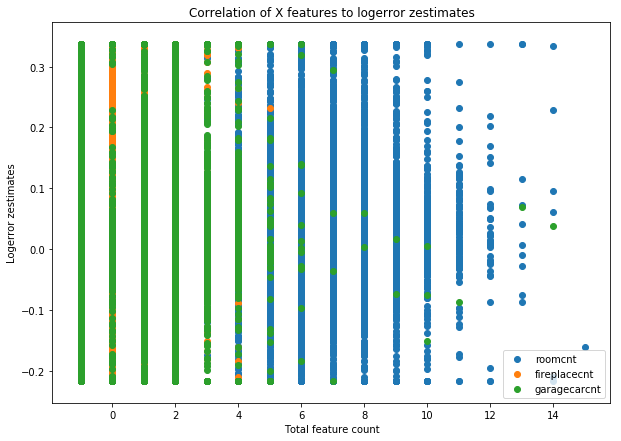

In [33]:
#Let's take at a few variables to determine how they are correlated with Y (logerror).
#Our dataframe contains columns with mix unit scales therefore, I will run the plot with a few variable that
#contain the same scale.
plt.figure(figsize=(10,7))
#plt.scatter(X['calculatedbathnbr'], y)
plt.scatter(X['roomcnt'], y, label='roomcnt')
plt.scatter(X['fireplacecnt'], y, label='fireplacecnt')
plt.scatter(X['garagecarcnt'], y, label='garagecarcnt')
plt.xlabel('Total feature count')
plt.ylabel('Logerror zestimates')
plt.title('Correlation of X features to logerror zestimates')
plt.legend()
plt.show()

In [34]:
#The graph above tells us that roomcnt and garagecarcnt have a correlation with the logerror but fireplacecnt
#dosn't have a strong correlation. This also tells me that as the Zestimate estimates performs well for 
#bigger size houses but fireplacecnt does not have much impact ont he Zestimate.

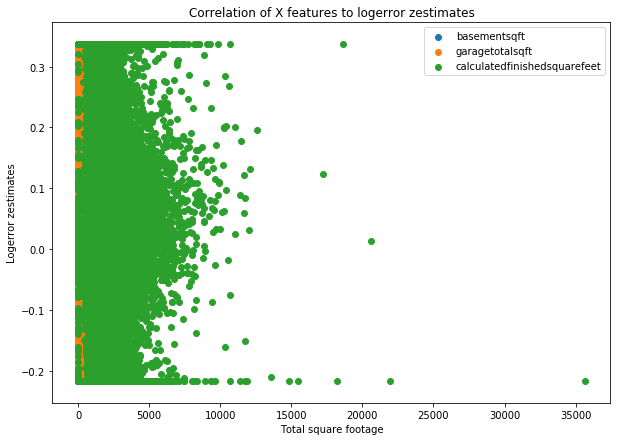

In [35]:
#Let's take at a few variables to determine how they are correlated with Y (logerror).
#Our dataframe contains columns with mix unit scales therefore, I will run the plot with a few variable that
#contain the same scale.

plt.figure(figsize=(10,7))
#plt.scatter(X['calculatedbathnbr'], y)
plt.scatter(X['basementsqft'], y, label='basementsqft')
plt.scatter(X['garagetotalsqft'], y, label='garagetotalsqft')
plt.scatter(X['calculatedfinishedsquarefeet'], y, label='calculatedfinishedsquarefeet')
plt.xlabel('Total square footage')
plt.ylabel('Logerror zestimates')
plt.title('Correlation of X features to logerror zestimates')
plt.legend()
plt.show()

In [36]:
#The graph above tells us that has calculatedfinishedsquarefeet increases the Logerror will increment. 
#The garagetotalsqft and basementsqft dose not have a strong correlation with logerror. 
#This means Zestimate estimates performs well for bigger size houses.

# Let's begin with our benchmark Model.

In [37]:
#set aside 20% of the data as a test set for evaluating our model. 
#set an arbitrary "random state" (a.k.a. seed) so that we can reproduce our results.
#good practice to stratify your sample by the target variable. This will ensure our 
#training set looks similar to your test set, making your evaluation metrics more reliable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), 
                                                    test_size=0.2, 
                                                    random_state=42)


In [38]:
#Many algorithms assume that all features are centered around zero and have approximately 
#the same variance. Standardizing the our features helps to accomplish the goal of 
#centering the data around zero. Based on plot above we see that we have outliers in our data 
#so utilizing the standardscaler function will ensure we address the outliers before running
#our model.

#import warnings
#warnings.filterwarnings("ignore")

#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         linear_model.Ridge())
 
#  Declare hyperparameters to tune
hyperparameters = { 'ridge__alpha' : [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 8, 10]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=5,return_train_score=True )
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

ridge_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
cv_mean_train = clf.cv_results_['mean_train_score'].mean()
cv_mean_test = clf.cv_results_['mean_test_score'].mean()
cv_std_train_score = clf.cv_results_['std_train_score'].mean()
cv_std_test_score = clf.cv_results_['std_test_score'].mean()



# R2 total variance explained by model) / total variance
print("R2 score : %.3f" % ridge_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',cv_mean_train)
print('CV mean test results:',cv_mean_test)
print('CV std mean results:',cv_std_train_score)
print('CV std test results:',cv_std_test_score)

#df_parameter = pd.DataFrame(hyperparameters)

R2 score : 0.005
Mean squared error: 0.008
Root Mean squared error: 0.089
Best alpha using built-in RidgeCV: {'ridge__alpha': 0.01}
CV mean train results: 0.011169629215622898
CV mean test results: 0.007842123322713404
CV std mean results: 0.00024766800658011556
CV std test results: 0.0011351700608435477


In [39]:
#create a result table
data = [{'Model':'Ridge', 'Best Parameter': clf.best_params_, 'CV mean train': cv_mean_train,
         'CV mean test': cv_mean_test,
        'R2': ridge_r2_score,'MSE': mse, 'RMSE': rmse}]
df_results = pd.DataFrame(data)

df_results


,Best Parameter,CV mean test,CV mean train,MSE,Model,R2,RMSE
0,{'ridge__alpha': 0.01},0.007842,0.01117,0.007981,Ridge,0.00494,0.089338


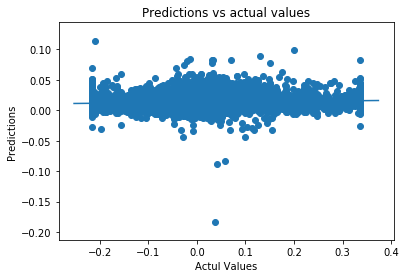

In [40]:
# graph my testing data against my actual data
# Add correlation line

plt.scatter(y_test, pred)
axes = plt.gca()
m, b = np.polyfit(y_test, pred, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

#plt.scatter(y_test, pred)
plt.xlabel('Actul Values')
plt.ylabel('Predictions')
plt.title('Predictions vs actual values')
plt.show()

In [41]:
#import warnings
#warnings.filterwarnings("ignore")

#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         linear_model.Lasso())
 
#  Declare hyperparameters to tune
hyperparameters = { 'lasso__alpha' : [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 8, 10]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=5 ,return_train_score=True)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

lasso_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
cv_mean_train = clf.cv_results_['mean_train_score'].mean()
cv_mean_test = clf.cv_results_['mean_test_score'].mean()


# R2 total variance explained by model) / total variance
print("R2 score : %.3f" % lasso_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',cv_mean_train)
print('CV mean test results:',cv_mean_test)
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())

R2 score : -0.000
Mean squared error: 0.008
Root Mean squared error: 0.090
Best alpha using built-in RidgeCV: {'lasso__alpha': 0.01}
CV mean train results: 0.0
CV mean test results: -4.209513712210011e-05
CV std mean results: 0.0
CV std test results: 4.946612325403259e-05


In [42]:
#update result table
data = [{'Model':'Lasso', 'Best Parameter': clf.best_params_,'CV mean train': cv_mean_train,
         'CV mean test': cv_mean_test,
        'R2': lasso_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

df_results

,Best Parameter,CV mean test,CV mean train,MSE,Model,R2,RMSE
0,{'ridge__alpha': 0.01},0.007842,0.01117,0.007981,Ridge,0.004940,0.089338
0,{'lasso__alpha': 0.01},-0.000042,0.00000,0.008022,Lasso,-0.000127,0.089565


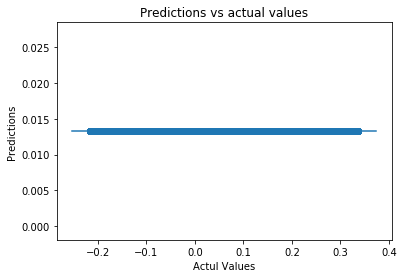

In [43]:
# graph my testing data against my actual data
# Add correlation line

plt.scatter(y_test, pred)
axes = plt.gca()
m, b = np.polyfit(y_test, pred, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

#plt.scatter(y_test, pred)
plt.xlabel('Actul Values')
plt.ylabel('Predictions')
plt.title('Predictions vs actual values')
plt.show()

In [44]:
#df_results = df_results.drop(0)
#df_results

In [45]:
# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=30))
 
#  Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1],
                  'randomforestregressor__n_estimators': [10, 20, 30, 40, 50]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

rfr_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
cv_mean_train = clf.cv_results_['mean_train_score'].mean()
cv_mean_test = clf.cv_results_['mean_test_score'].mean()

print("R2 score : %.3f" % rfr_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',cv_mean_train)
print('CV mean test results:',cv_mean_test)
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())


R2 score : 0.009
Mean squared error: 0.008
Root Mean squared error: 0.089
Best alpha using built-in RidgeCV: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 50}
CV mean train results: 0.21592102764047835
CV mean test results: -0.008732703349836555
CV std mean results: 0.0005460726839823725
CV std test results: 0.0019272465856390033


In [46]:
#update result table
data = [{'Model':'Random Forest', 'Best Parameter': clf.best_params_,'CV mean train': cv_mean_train,
         'CV mean test': cv_mean_test,
        'R2': rfr_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

df_results

,Best Parameter,CV mean test,CV mean train,MSE,Model,R2,RMSE
0,{'ridge__alpha': 0.01},0.007842,0.011170,0.007981,Ridge,0.004940,0.089338
0,{'lasso__alpha': 0.01},-0.000042,0.000000,0.008022,Lasso,-0.000127,0.089565
0,"{'randomforestregressor__max_depth': 5, 'rando...",-0.008733,0.215921,0.007952,Random Forest,0.008549,0.089176


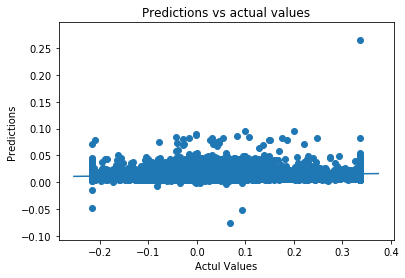

In [47]:
# graph my testing data against my actual data
# Add correlation line

plt.scatter(y_test, pred)
axes = plt.gca()
m, b = np.polyfit(y_test, pred, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

#plt.scatter(y_test, pred)
plt.xlabel('Actul Values')
plt.ylabel('Predictions')
plt.title('Predictions vs actual values')
plt.show()

In [48]:
#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         DecisionTreeRegressor())
 
#  Declare hyperparameters to tune
hyperparameters = { 'decisiontreeregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'decisiontreeregressor__max_depth': [5, 3, 1, 7, 9],
                  'decisiontreeregressor__max_leaf_nodes': [5, 10, 15, 20],
                  'decisiontreeregressor__min_samples_leaf': [10, 20, 30, 40]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

dtr_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
cv_mean_train = clf.cv_results_['mean_train_score'].mean()
cv_mean_test = clf.cv_results_['mean_test_score'].mean()

print("R2 score : %.3f" % dtr_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',cv_mean_train)
print('CV mean test results:',cv_mean_test)
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())

R2 score : 0.004
Mean squared error: 0.008
Root Mean squared error: 0.089
Best alpha using built-in RidgeCV: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_leaf_nodes': 10, 'decisiontreeregressor__min_samples_leaf': 40}
CV mean train results: 0.007818917085510236
CV mean test results: 0.0033429653293987217
CV std mean results: 0.0007652870147407319
CV std test results: 0.001721883960352583


In [49]:
#update result table
data = [{'Model':'Decision Tree', 'Best Parameter': clf.best_params_,'CV mean train': cv_mean_train,
         'CV mean test': cv_mean_test,
        'R2': dtr_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

#rearrange the column names

df_results = df_results[['Model', 'Best Parameter', 'CV mean train', 'CV mean test', 'R2', 'MSE', 'RMSE']]

df_results

,Model,Best Parameter,CV mean train,CV mean test,R2,MSE,RMSE
0,Ridge,{'ridge__alpha': 0.01},0.011170,0.007842,0.004940,0.007981,0.089338
0,Lasso,{'lasso__alpha': 0.01},0.000000,-0.000042,-0.000127,0.008022,0.089565
0,Random Forest,"{'randomforestregressor__max_depth': 5, 'rando...",0.215921,-0.008733,0.008549,0.007952,0.089176
0,Decision Tree,"{'decisiontreeregressor__max_depth': 5, 'decis...",0.007819,0.003343,0.003590,0.007992,0.089398


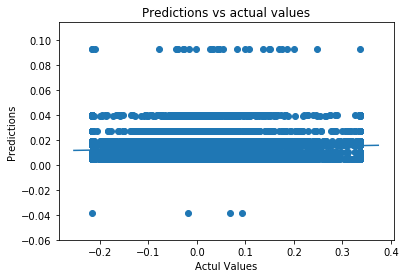

In [50]:
# graph my testing data against my actual data
# Add correlation line

plt.scatter(y_test, pred)
axes = plt.gca()
m, b = np.polyfit(y_test, pred, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

#plt.scatter(y_test, pred)
plt.xlabel('Actul Values')
plt.ylabel('Predictions')
plt.title('Predictions vs actual values')
plt.show()

# Summary: My benchmark model results are not good. The goal of the project was to build a model to improve the zillow Zestimate residual error (also know as the log-error). 

#The current Zestimate is at 0.06, therefore my model hasn't made an improvement. 

#However, the next set of steps would be to perform feature selection using only the most #important features and determine if the model improves. Based on our analysis above there #are few columns we can be further investigated to see if they can provide further insight #and more of a correlation with the output variable. I would also look to make more #changes with the hyperparameters. If all of the above still does not improve performance #then I would look to evaulate other models.